In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
filename = r"..\data\dataset0.json.gz"

In [3]:
DICT_KEYS = ['transcript_id', 'position', 'nanopore_read']
FEATURE_NAMES = [
    'dwelling_time_minus_1', 'std_minus_1', 'mean_current_minus_1', 
    'dwelling_time_0', 'std_0', 'mean_current_0', 
    'dwelling_time_plus_1', 'std_plus_1', 'mean_current_plus_1']


In [ ]:
def flatten_deep_data_by_keys():
    """
    Flattens a 4-level nested dictionary structure (dict{TID: dict{Pos: dict{RID: list[]}}})
    by explicitly using keys to access nested values.
    """
    file_path = r"..\data\dataset0.json.gz"
    rows = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            for transcript_id, positions in data.items():
                for transcript_position, sequences in positions.items():
                    for sequence, feature_list in sequences.items():
                        for features in feature_list:
                            row = {
                                'transcript_id': transcript_id,
                                'position': int(transcript_position),
                                'read_id': sequence,
                                'dwelling_time_minus_1': features[0],
                                'std_minus_1': features[1],
                                'mean_current_minus_1': features[2],
                                'dwelling_time_0': features[3],
                                'std_0': features[4],
                                'mean_current_0': features[5],
                                'dwelling_time_plus_1': features[6],
                                'std_plus_1': features[7],
                                'mean_current_plus_1': features[8],
                            }
                            rows.append(row)

    df = pd.DataFrame(rows)
    return df


In [5]:

# Execute the flattening process
flat_read_df = flatten_deep_data_by_keys()

print("\n--- Flattened Read-Level DataFrame ---")
print(f"Shape: {flat_read_df.shape} (Each row is one Nanopore read)")
print(flat_read_df.head())
# column names of the dataframe
#print(flat_read_df.columns.tolist())
# 1 row of the dataframe
#print(flat_read_df.iloc[0])


--- Flattened Read-Level DataFrame ---
Shape: (11027106, 12) (Each row is one Nanopore read)
     transcript_id  position  read_id  dwelling_time_minus_1  std_minus_1  \
0  ENST00000000233       244  AAGACCA                0.00299         2.06   
1  ENST00000000233       244  AAGACCA                0.00631         2.53   
2  ENST00000000233       244  AAGACCA                0.00465         3.92   
3  ENST00000000233       244  AAGACCA                0.00398         2.06   
4  ENST00000000233       244  AAGACCA                0.00664         2.92   

   mean_current_minus_1  dwelling_time_0  std_0  mean_current_0  \
0                 125.0          0.01770  10.40           122.0   
1                 125.0          0.00844   4.67           126.0   
2                 109.0          0.01360  12.00           124.0   
3                 125.0          0.00830   5.01           130.0   
4                 120.0          0.00266   3.94           129.0   

   dwelling_time_plus_1  std_plus_1  mea

In [6]:
def aggregate_to_site_level(flat_read_df, features_to_aggregate):
    """
    Groups the read-level DataFrame by site, calculates features, 
    and collects a unique list (set) of read_ids.
    """
    
    # 1. Define aggregation functions
    agg_funcs = {}
    for feature in features_to_aggregate:
        agg_funcs[feature] = ['mean', 'std']  # Keeps std dev

    # 2. Perform the aggregation
    site_features_grouped = flat_read_df.groupby(['transcript_id', 'position', 'read_id']).agg(agg_funcs)
    
    # 3. Flatten the multi-level column names for a clean DataFrame
    new_columns = []
    for col in site_features_grouped.columns:
            new_columns.append(f'{col[0]}_{col[1]}')
            
    site_features_grouped.columns = new_columns
    
    # 4. Prepare final feature matrix with site_id
    feature_matrix = site_features_grouped.reset_index()
    feature_matrix['site_id'] = feature_matrix['transcript_id'] + '@' + feature_matrix['position'].astype(str)
    
    print(f"Aggregation complete. Feature matrix shape: {feature_matrix.shape}")
    print(f"New column 'unique_read_ids_set' contains the unique list of read IDs per site.")
    
    return feature_matrix

In [7]:
summarized_df = aggregate_to_site_level(flat_read_df, FEATURE_NAMES)

print("\n--- Aggregated DataFrame ---")
print(f"Shape: {summarized_df.shape} (Each row is one Nanopore read)")
#print(summarized_df.head())
# column names of the dataframe
print(summarized_df.columns.tolist())
# 1 row of the dataframe

Aggregation complete. Feature matrix shape: (121838, 22)
New column 'unique_read_ids_set' contains the unique list of read IDs per site.

--- Aggregated DataFrame ---
Shape: (121838, 22) (Each row is one Nanopore read)
['transcript_id', 'position', 'read_id', 'dwelling_time_minus_1_mean', 'dwelling_time_minus_1_std', 'std_minus_1_mean', 'std_minus_1_std', 'mean_current_minus_1_mean', 'mean_current_minus_1_std', 'dwelling_time_0_mean', 'dwelling_time_0_std', 'std_0_mean', 'std_0_std', 'mean_current_0_mean', 'mean_current_0_std', 'dwelling_time_plus_1_mean', 'dwelling_time_plus_1_std', 'std_plus_1_mean', 'std_plus_1_std', 'mean_current_plus_1_mean', 'mean_current_plus_1_std', 'site_id']


In [8]:
labels = r"..\data\data.info.labelled"

In [9]:
def load_and_merge_labels_csv(feature_matrix, label_file_path='data.info'):
    """
    Loads a CSV label file with a header and merges it with the site-level 
    feature matrix using a newly created site_id.
    """
    
    # 1. Load the CSV file. Pandas correctly assumes header=0 and sep=',' by default.
    label_df = pd.read_csv(label_file_path)
    
    # 2. Create the 'site_id' column in the label DataFrame to match the features
    label_df['site_id'] = label_df['transcript_id'] + '@' + label_df['transcript_position'].astype(str)
    
    # 3. Select the essential columns for merging
    label_subset = label_df[['site_id', 'gene_id', 'label']].copy()
    
    # 4. Merge Features and Labels on 'site_id'
    final_dataset = pd.merge(
        feature_matrix, 
        label_subset, 
        on='site_id', 
        how='inner' 
    )
    
    print(f"✅ Successfully created the final training dataset! Shape: {final_dataset.shape}")
    print("\nTarget Label Distribution (crucial for class imbalance analysis):")
    print(final_dataset['label'].value_counts(normalize=True))
    
    return final_dataset

# Assuming 'feature_matrix' is the aggregated result from the previous step:
# final_dataset = load_and_merge_labels_csv(feature_matrix, 'data.info')

In [10]:
full_df = load_and_merge_labels_csv(summarized_df, labels)
print("\n--- Labelled DataFrame ---")
print(f"Shape: {full_df.shape} (Each row is one Nanopore read)")
#print(full_df.head())
print(full_df.shape)


✅ Successfully created the final training dataset! Shape: (121838, 24)

Target Label Distribution (crucial for class imbalance analysis):
label
0    0.955063
1    0.044937
Name: proportion, dtype: float64

--- Labelled DataFrame ---
Shape: (121838, 24) (Each row is one Nanopore read)
(121838, 24)


In [11]:
def encode_7mer_as_integers(df, sequence_column):
    """
    Encode 7-mer sequences as integer features (A=0, C=1, G=2, T=3).
    Adds 7 new columns for positions -3 to +3.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with a column containing 7-mer sequences
    sequence_column : str
        Name of the column with 7-mer sequences (e.g., 'sequence', 'kmer', etc.)
    
    Returns:
    --------
    pd.DataFrame : Original DataFrame with 7 new integer-encoded columns added
    """
    # Base to integer mapping
    base_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'U': 4}
    positions = ['-3', '-2', '-1', '0', '+1', '+2', '+3']
    
    # Create integer-encoded columns for each position
    for i, pos in enumerate(positions):
        col_name = f'seq_{pos}'
        df[col_name] = df[sequence_column].str[i].str.upper().map(base_map)
    
    print(f"Added 7 integer-encoded sequence features")
    return df

In [12]:
encoded_df = encode_7mer_as_integers(full_df, 'read_id')
print(encoded_df.shape)
print(encoded_df.columns.tolist())

Added 7 integer-encoded sequence features
(121838, 31)
['transcript_id', 'position', 'read_id', 'dwelling_time_minus_1_mean', 'dwelling_time_minus_1_std', 'std_minus_1_mean', 'std_minus_1_std', 'mean_current_minus_1_mean', 'mean_current_minus_1_std', 'dwelling_time_0_mean', 'dwelling_time_0_std', 'std_0_mean', 'std_0_std', 'mean_current_0_mean', 'mean_current_0_std', 'dwelling_time_plus_1_mean', 'dwelling_time_plus_1_std', 'std_plus_1_mean', 'std_plus_1_std', 'mean_current_plus_1_mean', 'mean_current_plus_1_std', 'site_id', 'gene_id', 'label', 'seq_-3', 'seq_-2', 'seq_-1', 'seq_0', 'seq_+1', 'seq_+2', 'seq_+3']


In [13]:
sequence_cols = ['seq_-3', 'seq_-2', 'seq_-1', 'seq_0', 'seq_+1', 'seq_+2', 'seq_+3']

print("Summary of all sequence columns:")
for col in sequence_cols:
    unique_vals = encoded_df[col].value_counts(dropna=False)
    missing = encoded_df[col].isna().sum()
    print(f"\n{col}:")
    print(f"  Missing values: {missing}")
    print(f"  Unique values: {unique_vals.index.tolist()}")
    print(f"  Value counts:\n{unique_vals}")

Summary of all sequence columns:

seq_-3:
  Missing values: 0
  Unique values: [1, 3, 4, 2]
  Value counts:
seq_-3
1    38866
3    31600
4    28828
2    22544
Name: count, dtype: int64

seq_-2:
  Missing values: 0
  Unique values: [1, 3, 4]
  Value counts:
seq_-2
1    45867
3    42066
4    33905
Name: count, dtype: int64

seq_-1:
  Missing values: 0
  Unique values: [3, 1]
  Value counts:
seq_-1
3    63853
1    57985
Name: count, dtype: int64

seq_0:
  Missing values: 0
  Unique values: [1]
  Value counts:
seq_0
1    121838
Name: count, dtype: int64

seq_+1:
  Missing values: 0
  Unique values: [2]
  Value counts:
seq_+1
2    121838
Name: count, dtype: int64

seq_+2:
  Missing values: 0
  Unique values: [1, 4, 2]
  Value counts:
seq_+2
1    45622
4    39587
2    36629
Name: count, dtype: int64

seq_+3:
  Missing values: 0
  Unique values: [4, 1, 3, 2]
  Value counts:
seq_+3
4    34922
1    31695
3    29472
2    25749
Name: count, dtype: int64


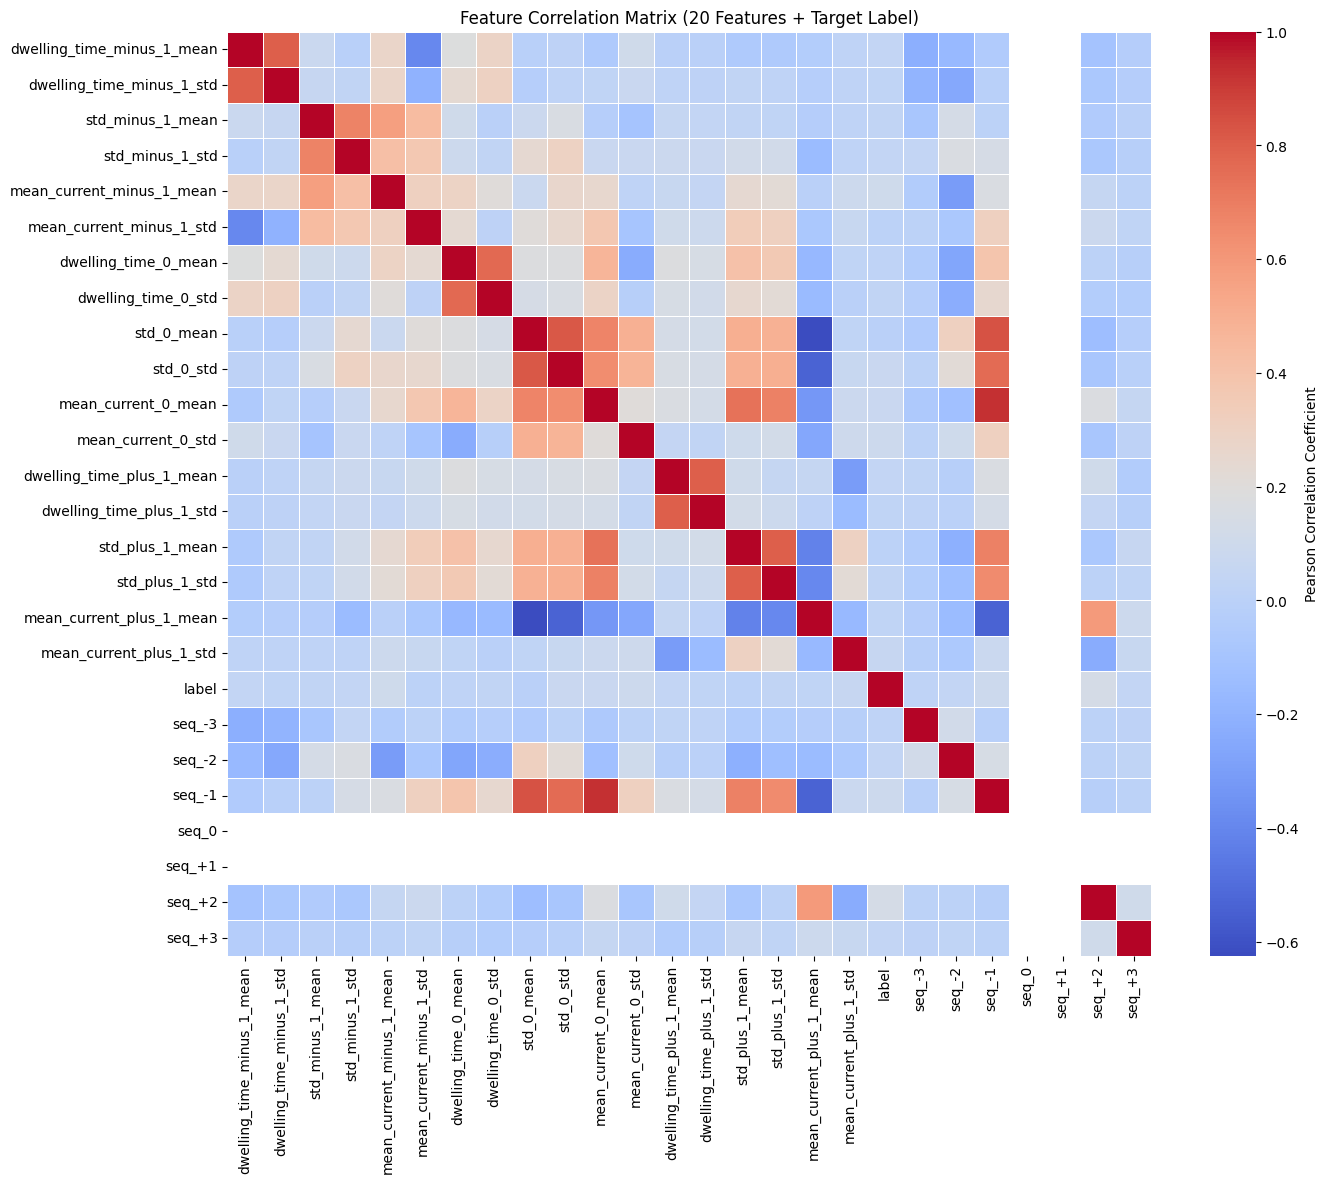

In [14]:
# --- 1. Prepare Features (Log Transformation for Read Count) ---
label_cols =(['transcript_id', 'position', 'read_id', 'site_id', 'gene_id'])
seq_col = (['seq_-3', 'seq_-2', 'seq_-1', 'seq_0', 'seq_+1', 'seq_+2', 'seq_+3'])

# --- 2. Define the Columns for Correlation ---
feature_cols = [
    'dwelling_time_minus_1_mean', 'dwelling_time_minus_1_std', 
    'std_minus_1_mean', 'std_minus_1_std', 
    'mean_current_minus_1_mean', 'mean_current_minus_1_std', 

    'dwelling_time_0_mean', 'dwelling_time_0_std', 
    'std_0_mean', 'std_0_std', 
    'mean_current_0_mean', 'mean_current_0_std', 

    'dwelling_time_plus_1_mean', 'dwelling_time_plus_1_std', 
    'std_plus_1_mean', 'std_plus_1_std', 
    'mean_current_plus_1_mean', 'mean_current_plus_1_std', 

    'label', 
    'seq_-3', 'seq_-2', 'seq_-1', 'seq_0', 'seq_+1', 'seq_+2', 'seq_+3'
]

# Select the relevant data subset
corr_data = encoded_df[feature_cols]

# --- 3. Calculate Correlation Matrix ---
correlation_matrix = corr_data.corr()

# --- 4. Visualize with Heatmap ---
plt.figure(figsize=(15, 12)) # Increased size for better readability
sns.heatmap(
    correlation_matrix,
    annot=False, 
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    square=True,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)
plt.title('Feature Correlation Matrix (20 Features + Target Label)')
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Assuming 'final_dataset' is your DataFrame after feature aggregation and label merging.
# It MUST contain the 'gene_id' and 'label' columns.

# 1. Separate features (X) and target (y)
# Drop all non-feature columns except 'gene_id' (needed for splitting)
gene_ids_col = encoded_df['gene_id'] # Keep this separate for splitting
X = encoded_df.drop(label_cols, axis=1)
y = encoded_df['label']

# 2. Split the unique gene IDs (80% for training, 20% for testing)
unique_genes = gene_ids_col.unique()

# Split the list of unique gene IDs
train_genes, test_genes = train_test_split(
    unique_genes, 
    test_size=0.2, 
    random_state=42 # Use a fixed seed for reproducible results!
)

# 3. Create the final train and test indices based on the gene split
# This avoids data leakage by ensuring all sites from a test gene are in the test set.
train_indices = encoded_df['gene_id'].isin(train_genes)
test_indices = encoded_df['gene_id'].isin(test_genes)


# 4. Apply indices to features (X) and target (y)
X_train = X[train_indices].drop(columns=['label'])
X_test = X[test_indices].drop(columns=['label'])
y_train = y[train_indices]
y_test = y[test_indices]

print("--- Gene-Level Split Results ---")
print(f"Total Unique Genes: {len(unique_genes)}")
print(f"Train Genes: {len(train_genes)}, Test Genes: {len(test_genes)}")
print(f"X_train shape: {X_train.shape} (Sites for training)")
print(f"X_test shape: {X_test.shape} (Pristine sites for final evaluation)")

--- Gene-Level Split Results ---
Total Unique Genes: 3852
Train Genes: 3081, Test Genes: 771
X_train shape: (96821, 25) (Sites for training)
X_test shape: (25017, 25) (Pristine sites for final evaluation)


In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import pandas as pd

In [18]:

# Instantiate SMOTE. We target a 1:1 ratio (fully balanced).
# You can experiment with different ratios (e.g., 0.5 for 2:1)
smote = SMOTE(
    sampling_strategy='auto', 
    random_state=42,
)

print("\n--- Applying SMOTE to Training Data ---")

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate and display the change in class balance
print(f"Original Training Class Count (Label 1): {sum(y_train == 1):,}")
print(f"Resampled Training Class Count (Label 1): {sum(y_train_resampled == 1):,}")
print(f"X_train_resampled shape: {X_train_resampled.shape} (Balanced training data)")

# Check the new distribution
print("\nNew Training Label Distribution:")
print(y_train_resampled.value_counts())


--- Applying SMOTE to Training Data ---
Original Training Class Count (Label 1): 4,421
Resampled Training Class Count (Label 1): 92,400
X_train_resampled shape: (184800, 25) (Balanced training data)

New Training Label Distribution:
label
0    92400
1    92400
Name: count, dtype: int64


In [19]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import time

In [20]:
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name):
    """Trains a model and evaluates its performance on the test set."""
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability for positive class (label=1)
    
    # Calculate requested metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    # Calculate a project-critical metric (ROC AUC)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (Accuracy of positive predictions)")
    print(f"Recall: {recall:.4f} (Ability to find all positive samples)")
    print(f"ROC AUC: {roc_auc:.4f} (Overall separation power)")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

    return {
        'Model': model_name, 
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'ROC AUC': roc_auc
    }

In [ ]:
# --------------------------------------------------------------------------------------
# 1. Random Forest Classifier
# --------------------------------------------------------------------------------------

rf_model = RandomForestClassifier(
    n_estimators=200,           
    max_depth=10,               # Reduced from 15 to prevent overfitting
    min_samples_split=50,       # Increased from 15 (more regularization)
    min_samples_leaf=20,        # Increased from 5 (more regularization)
    max_features='sqrt',        # Limit features per split (reduces variance)
    min_impurity_decrease=0.001, 
    max_samples=0.8,            
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)


In [22]:
# --------------------------------------------------------------------------------------
# 2. XGBoost Classifier
# --------------------------------------------------------------------------------------

import xgboost as xgb

# XGBoost with regularization to prevent overfitting
xgb_model = xgb.XGBClassifier(
    n_estimators=200,              # Number of boosting rounds
    max_depth=6,                   # Shallower trees than RF (typical for XGBoost)
    learning_rate=0.05,            # Lower learning rate for better generalization
    subsample=0.8,                 # Use 80% of samples (similar to RF max_samples)
    colsample_bytree=0.8,          # Use 80% of features per tree
    colsample_bylevel=0.8,         # Feature sampling per level
    min_child_weight=10,           # Minimum sum of instance weight in a child (like min_samples_leaf)
    gamma=0.1,                     # Minimum loss reduction for split (regularization)
    reg_alpha=0.1,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    scale_pos_weight=None,         # Will calculate from data for imbalance
    random_state=42,
    n_jobs=-1,
    tree_method='hist',            # Faster histogram-based method
    eval_metric='logloss'          # Evaluation metric
)

In [23]:
# --------------------------------------------------------------------------------------
# 3. LightGBM - Faster than XGBoost, often similar performance
# --------------------------------------------------------------------------------------

import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,                 # LightGBM uses leaf-wise growth
    subsample=0.8,                 # Row sampling
    colsample_bytree=0.8,          # Column sampling
    min_child_samples=20,          # Like min_samples_leaf
    min_split_gain=0.1,            # Like min_impurity_decrease
    reg_alpha=0.1,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [24]:
# --------------------------------------------------------------------------------------
# 8. Voting Ensemble - Combine multiple models
# --------------------------------------------------------------------------------------

from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    voting='soft',  # Use probability averaging
    n_jobs=-1
)

In [25]:
ens_results = evaluate_classifier(
    ensemble_model, 
    X_train_resampled, y_train_resampled, 
    X_test, y_test, 
    "Ensemble Model"
)


--- Ensemble Model Results ---
Training Time: 39.36 seconds
Accuracy: 0.8745
Precision: 0.2244 (Accuracy of positive predictions)
Recall: 0.8055 (Ability to find all positive samples)
ROC AUC: 0.9218 (Overall separation power)
Confusion Matrix:
[[21028  2935]
 [  205   849]]


Text(0.5, 1.0, 'Ensemble model ROC AUC Curve')

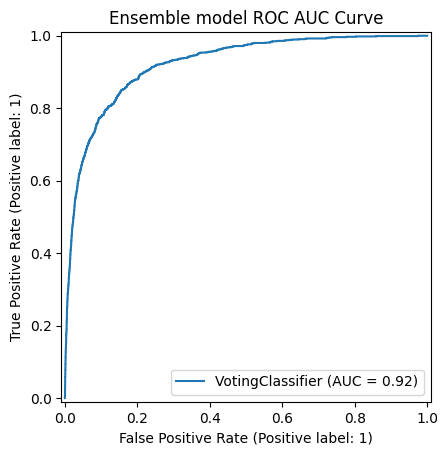

In [26]:
# plot ROC AUC curve for rf_model
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(ensemble_model, X_test, y_test)
plt.title('Ensemble model ROC AUC Curve')

Text(0.5, 1.0, 'Ensemble model PR AUC Curve')

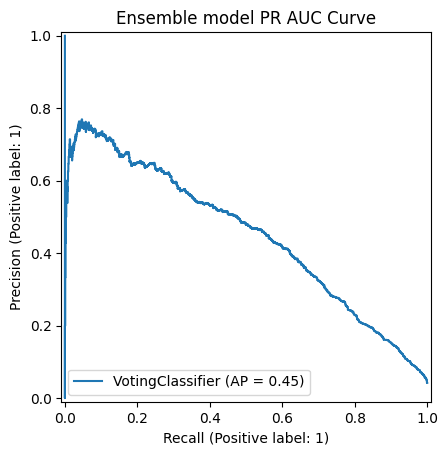

In [27]:
# plot PR AUC curve for rf_model
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(ensemble_model, X_test, y_test)
plt.title('Ensemble model PR AUC Curve')

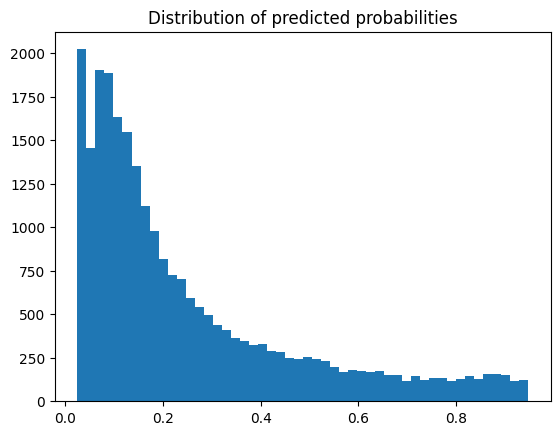

In [28]:
import matplotlib.pyplot as plt
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]
plt.hist(y_pred_proba, bins=50)
plt.title("Distribution of predicted probabilities")
plt.show()

In [29]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, GroupKFold

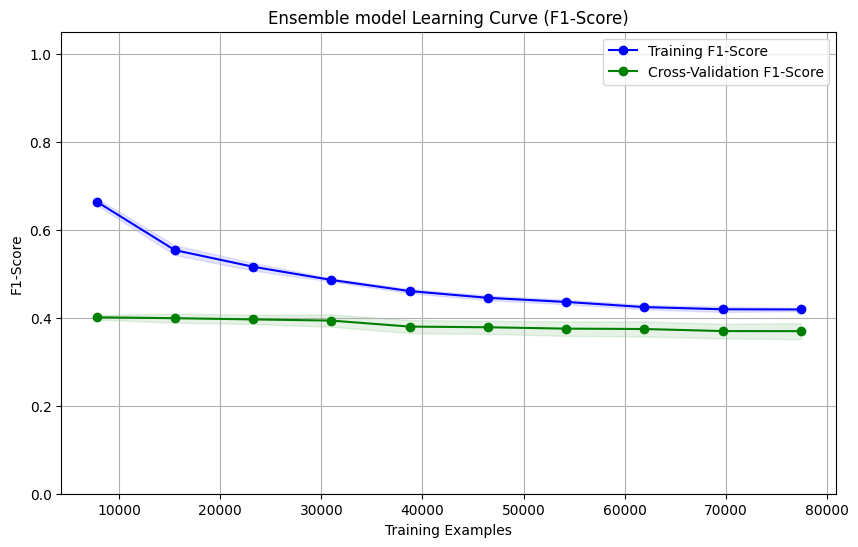

In [30]:
# 1. Define the SMOTE-RandomForest Pipeline
#    SMOTE will only be applied to the data within each CV training fold.
smote_rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', ensemble_model) # Assuming rf_final_clean is a RandomForestClassifier instance
])

# 2. Run learning_curve using the Pipeline
#    NOTE: Use the ORIGINAL, UNSAMPLED training data here (X_train, y_train),
#          NOT the already resampled data (X_train_resampled).
group_cv = GroupKFold(n_splits=5)

# 4. Use learning_curve with grouped CV
train_sizes, train_scores, test_scores = learning_curve(
    estimator=smote_rf_pipeline,
    X=X_train,
    y=y_train,
    groups=encoded_df[train_indices]["gene_id"],  # Pass gene IDs as groups
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=group_cv,  # Use GroupKFold instead of integer
    scoring="f1",
    n_jobs=-1,
    random_state=42
)

# 3. Calculate mean and standard deviation for the scores (same as before)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 4. Plot the Learning Curve
plt.figure(figsize=(10, 6))
plt.title("Ensemble model Learning Curve (F1-Score)")
plt.xlabel("Training Examples")
plt.ylabel("F1-Score") # Corrected Y-axis label
plt.grid(True)

# Plot training score
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training F1-Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")

# Plot cross-validation score
plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-Validation F1-Score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.ylim([0.0, 1.05])
plt.show()